In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.spatial.distance import braycurtis

## Dataset processing

In [2]:
#Based on Joaquín Torres-Sospedra et al work, "Comprehensive analysis of distance and similarity measures for Wi-Fi fingerprinting indoor positioning systems"
def exponential_representation(rssi_matrix, rssi_min=-100, alpha=20):
    """
    Apply Sospedra's exponential transformation to a matrix of RSSI values.

    Parameters:
        rssi_matrix (np.ndarray): Raw RSSI values (samples x APs), typically in dBm (negative).
        rssi_min (int): Minimum RSSI reference for shifting values (according to paper, detected measurements range from −100 to −35 dBm).
        alpha (float): Scaling parameter.

    Returns:
        np.ndarray: Transformed RSSI values using exponential representation.
    """
    positive_repr = rssi_matrix - rssi_min  # Shift values to positive domain
    numerator = np.exp(positive_repr / alpha)
    denominator = np.exp(-rssi_min / alpha)
    return numerator / denominator

In [3]:
device_id_to_name_map = {1: "Galaxy S20", 2:"Galaxy S7", 3:"POCO X3", 4:"Galaxy Tab S7", 5:"Galaxy A12"}
device_ids = [1, 2, 3, 4, 5]

coordinates_cols = ["x", "y", "z", "floor_id","building_id", "device_id"]
fingerptins_cols = [f"AP{i}" for i in range(1, 311)]

coordinates_testing = pd.read_csv('DATASET/Coordinates_testing.csv', names = coordinates_cols, header = None)
coordinates_training = pd.read_csv('DATASET/Coordinates_training.csv', names = coordinates_cols, header = None)

RSS_testing_raw = pd.read_csv('DATASET/RSS_testing.csv', names = fingerptins_cols, header = None)
RSS_training_raw = pd.read_csv('DATASET/RSS_training.csv', names = fingerptins_cols, header = None)
RSS_training_raw.replace(100, -130, inplace=True)
RSS_testing_raw.replace(100, -130, inplace=True)

In [4]:
# ----- Load and apply exponential transformation to RSSI -----
RSS_testing = exponential_representation(RSS_testing_raw)
RSS_training = exponential_representation(RSS_training_raw)

## Model definition

In [6]:
# Same model configuration for all experiments, based on best positioning performance with respect to the 3D positioning error
#  of the ﬁne-tuned kNN algorithm from TUJI1 authors, following "A Comprehensive and Reproducible Comparison of Clustering and Optimization Rules in Wi-Fi Fingerprinting" 

k_neighbors = 7

def sorensen_distance(x, y):
    # Ensure float for division
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    return braycurtis(x, y)

class KNN_Sorensen(KNeighborsRegressor):
    def __init__(self, n_neighbors=k_neighbors):
        super().__init__(n_neighbors=n_neighbors, metric=sorensen_distance, algorithm='brute')


## Per-device experiments

### Per-Device Train & Test

In [7]:
results_per_device = {}

for device_id in device_ids:
    # Split train/test based on device
    train_mask = coordinates_training["device_id"] == device_id
    test_mask = coordinates_testing["device_id"] == device_id

    X_train_per_device = RSS_training[train_mask].values
    y_train_per_device = coordinates_training[train_mask][['x', 'y', 'z']].values

    X_test_per_device = RSS_testing[test_mask].values
    y_test_per_device = coordinates_testing[test_mask][['x', 'y', 'z']].values


    # Fit the kNN model
    knn_LODO = KNN_Sorensen(n_neighbors=7)
    knn_LODO.fit(X_train_per_device, y_train_per_device)
    y_pred_per_device = knn_LODO.predict(X_test_per_device)

    # Compute localization errors
    errors = np.linalg.norm(y_pred_per_device - y_test_per_device, axis=1)
    results_per_device[device_id] = {
        "mean": np.mean(errors),
        "median": np.median(errors),
        "std": np.std(errors),
    }

    print(f"[Per-device Test, Device: {device_id_to_name_map[device_id]}]")
    print(f"Mean error: {results_per_device[device_id]['mean']:.3f} m")
    print(f"Median error: {results_per_device[device_id]['median']:.3f} m")
    print(f"Std deviation: {results_per_device[device_id]['std']:.3f} m\n")

[Per-device Test, Device: Galaxy S20]
Mean error: 1.979 m
Median error: 1.669 m
Std deviation: 1.211 m

[Per-device Test, Device: Galaxy S7]
Mean error: 2.154 m
Median error: 1.964 m
Std deviation: 1.215 m

[Per-device Test, Device: POCO X3]
Mean error: 2.024 m
Median error: 1.802 m
Std deviation: 1.289 m

[Per-device Test, Device: Galaxy Tab S7]
Mean error: 1.925 m
Median error: 1.726 m
Std deviation: 1.168 m

[Per-device Test, Device: Galaxy A12]
Mean error: 3.167 m
Median error: 2.845 m
Std deviation: 1.895 m



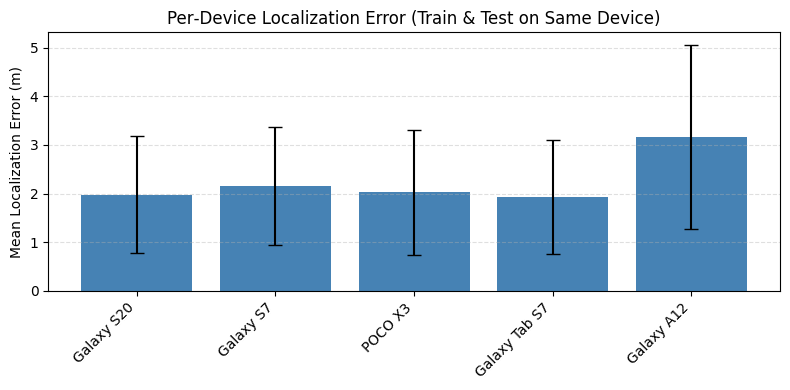

In [ ]:
device_names = [device_id_to_name_map[d] for d in device_ids]
mean_errors  = [results_per_device[d]["mean"]  for d in device_ids]
std_errors   = [results_per_device[d]["std"]   for d in device_ids]

x_pos = np.arange(len(device_ids))

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(x_pos, mean_errors, yerr=std_errors, capsize=5, color="steelblue")
plt.xticks(x_pos, device_names, rotation=45, ha='right')
plt.ylabel("Mean Localization Error (m)")
plt.title("Per‑Device Localization Error (Train & Test on Same Device)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig("train_test_same_device_plot")
plt.show()

### Train on One, Test on Others

In [9]:
# Perform Leave-One-Device-In (Train-on-One, Test-on-Others)
results_LODI = []

for train_device_id, train_device_name in device_id_to_name_map.items():
    # Train on one device
    train_mask = coordinates_training["device_id"] == train_device_id
    X_train_LODI = RSS_training[train_mask].values
    y_train_LODI = coordinates_training[train_mask][['x', 'y', 'z']].values

    for test_device_id, test_device_name in device_id_to_name_map.items():
        # Test on all the other devices except the one used for train
        if test_device_id == train_device_id:
            continue  # skip same device

        test_mask = coordinates_testing["device_id"] == test_device_id
        X_test_LODI = RSS_testing[test_mask].values
        y_test_LODI = coordinates_testing[test_mask][['x', 'y', 'z']].values

        knn = KNN_Sorensen(n_neighbors=k_neighbors)
        knn.fit(X_train_LODI, y_train_LODI)
        y_pred_LODI = knn.predict(X_test_LODI)

        errors = np.linalg.norm(y_pred_LODI - y_test_LODI, axis=1)
        results_LODI.append({
            "Train Device": train_device_name,
            "Test Device": test_device_name,
            "Mean Error (m)": np.mean(errors),
            "Median Error (m)": np.median(errors),
            "Std Error (m)": np.std(errors)
        })

# Display results
import pandas as pd
results_df = pd.DataFrame(results_LODI)
print(results_df.pivot(index="Train Device", columns="Test Device", values="Mean Error (m)").round(3))

Test Device    Galaxy A12  Galaxy S20  Galaxy S7  Galaxy Tab S7  POCO X3
Train Device                                                            
Galaxy A12            NaN       2.948      3.175          3.113    2.893
Galaxy S20          4.203         NaN      2.301          2.515    2.361
Galaxy S7           4.304       2.453        NaN          2.828    2.542
Galaxy Tab S7       4.796       3.168      3.545            NaN    2.899
POCO X3             3.871       2.338      2.388          2.425      NaN


### Cross-device generalization

#### Leave_One_Device_Out (LODO)

In [10]:
results_LODO = {}

for test_device in device_ids:
    # Split train/test based on device
    train_mask = coordinates_training["device_id"] != test_device
    test_mask = coordinates_testing["device_id"] == test_device

    X_train_LODO = RSS_training[train_mask].values
    y_train_LODO = coordinates_training[train_mask][['x', 'y', 'z']].values

    X_test_LODO = RSS_testing[test_mask].values
    y_test_LODO = coordinates_testing[test_mask][['x', 'y', 'z']].values


    # Fit the kNN model
    knn_LODO = KNN_Sorensen(n_neighbors=7)
    knn_LODO.fit(X_train_LODO, y_train_LODO)
    y_pred_LODO = knn_LODO.predict(X_test_LODO)

    # Compute localization errors
    errors = np.linalg.norm(y_pred_LODO - y_test_LODO, axis=1)
    results_LODO[test_device] = {
        "mean": np.mean(errors),
        "median": np.median(errors),
        "std": np.std(errors),
    }

    print(f"[LODO Test Device: {device_id_to_name_map[test_device]}]")
    print(f"Mean error: {results_LODO[test_device]['mean']:.2f} m")
    print(f"Median error: {results_LODO[test_device]['median']:.2f} m")
    print(f"Std deviation: {results_LODO[test_device]['std']:.2f} m\n")

[LODO Test Device: Galaxy S20]
Mean error: 2.33 m
Median error: 2.05 m
Std deviation: 1.43 m

[LODO Test Device: Galaxy S7]
Mean error: 2.35 m
Median error: 2.15 m
Std deviation: 1.38 m

[LODO Test Device: POCO X3]
Mean error: 2.37 m
Median error: 2.15 m
Std deviation: 1.48 m

[LODO Test Device: Galaxy Tab S7]
Mean error: 2.41 m
Median error: 2.07 m
Std deviation: 1.53 m

[LODO Test Device: Galaxy A12]
Mean error: 4.18 m
Median error: 3.61 m
Std deviation: 2.96 m



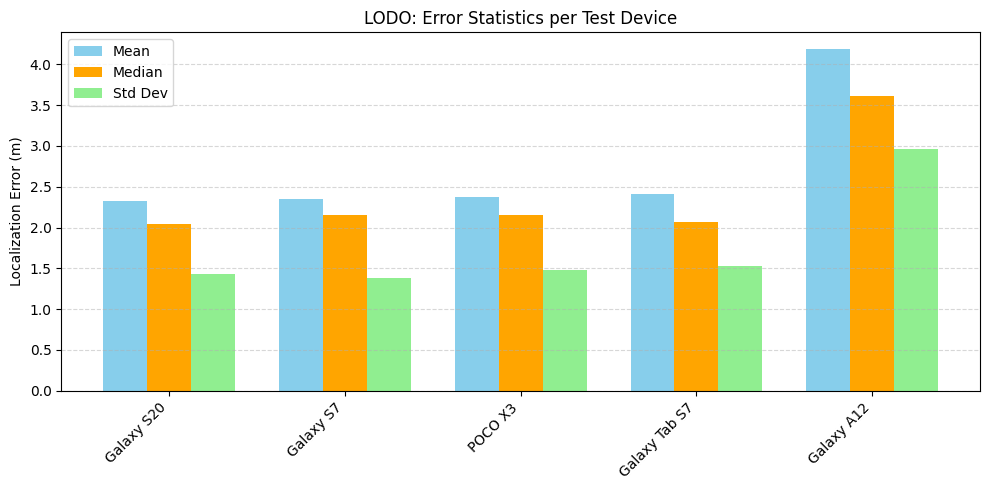

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Device names and values
device_names = [device_id_to_name_map[d] for d in device_ids]
mean_vals = [results_LODO[d]['mean'] for d in device_ids]
median_vals = [results_LODO[d]['median'] for d in device_ids]
std_vals = [results_LODO[d]['std'] for d in device_ids]

x = np.arange(len(device_ids))  # the label locations
width = 0.25  # width of each bar

# Create plot
plt.figure(figsize=(10, 5))
plt.bar(x - width, mean_vals, width, label='Mean', color='skyblue')
plt.bar(x, median_vals, width, label='Median', color='orange')
plt.bar(x + width, std_vals, width, label='Std Dev', color='lightgreen')

# Labels and ticks
plt.xticks(x, device_names, rotation=45, ha='right')
plt.ylabel("Localization Error (m)")
plt.title("LODO: Error Statistics per Test Device")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig("leave_one_device_out_plot")
plt.show()


#### Train on All Devices, Test per Device

In [12]:
results_TATD = {}

# Split train/test based on device
X_train_TATD = RSS_training.values
y_train__TATD = coordinates_training[['x', 'y', 'z']].values


# Fit the kNN model
knn_TATD = KNN_Sorensen(n_neighbors=7)
knn_TATD.fit(X_train_TATD, y_train__TATD)

for test_device in device_ids:

    test_mask = coordinates_testing["device_id"] == test_device

    X_test_TATD = RSS_testing[test_mask].values
    y_test_TATD = coordinates_testing[test_mask][['x', 'y', 'z']].values
    y_pred_TATD = knn_TATD.predict(X_test_TATD)

    # Compute localization errors
    errors = np.linalg.norm(y_pred_TATD - y_test_TATD, axis=1)
    results_TATD[test_device] = {
        "mean": np.mean(errors),
        "median": np.median(errors),
        "std": np.std(errors),
    }

    print(f"[TATD Test Device: {device_id_to_name_map[test_device]}]")
    print(f"Mean error: {results_TATD[test_device]['mean']:.2f} m")
    print(f"Median error: {results_TATD[test_device]['median']:.2f} m")
    print(f"Std deviation: {results_TATD[test_device]['std']:.2f} m\n")

[TATD Test Device: Galaxy S20]
Mean error: 1.98 m
Median error: 1.69 m
Std deviation: 1.20 m

[TATD Test Device: Galaxy S7]
Mean error: 2.13 m
Median error: 2.00 m
Std deviation: 1.20 m

[TATD Test Device: POCO X3]
Mean error: 2.00 m
Median error: 1.75 m
Std deviation: 1.29 m

[TATD Test Device: Galaxy Tab S7]
Mean error: 1.96 m
Median error: 1.73 m
Std deviation: 1.24 m

[TATD Test Device: Galaxy A12]
Mean error: 3.17 m
Median error: 2.84 m
Std deviation: 1.90 m



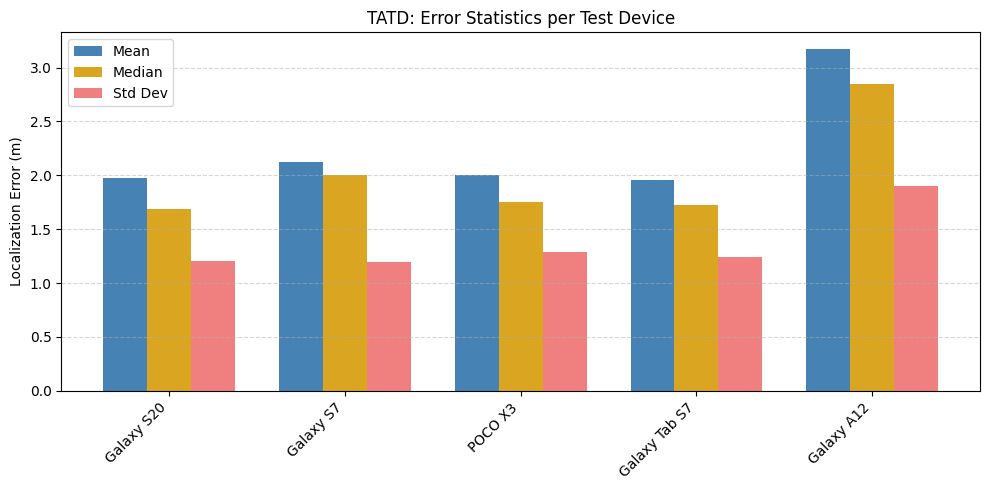

In [19]:
# Device names and values
device_names = [device_id_to_name_map[d] for d in device_ids]
mean_vals = [results_TATD[d]['mean'] for d in device_ids]
median_vals = [results_TATD[d]['median'] for d in device_ids]
std_vals = [results_TATD[d]['std'] for d in device_ids]

x = np.arange(len(device_ids))  # the label locations
width = 0.25  # width of each bar

# Create plot
plt.figure(figsize=(10, 5))
plt.bar(x - width, mean_vals, width, label='Mean', color='steelblue')
plt.bar(x, median_vals, width, label='Median', color='goldenrod')
plt.bar(x + width, std_vals, width, label='Std Dev', color='lightcoral')

# Labels and ticks
plt.xticks(x, device_names, rotation=45, ha='right')
plt.ylabel("Localization Error (m)")
plt.title("TATD: Error Statistics per Test Device")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig("train_all_test_per_device_plot")
plt.show()
